In [16]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [17]:
#Extract features (mfcc, chroma, mel) from a sound file

def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype = "float32")
        sample_rate = sound_file.samplerate
        if chroma:
            stft = np.abs(librosa.stft(X))
            result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y = X, sr = sample_rate, n_mfcc = 40).T, axis = 0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis = 0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr = sample_rate).T, axis = 0)
            result = np.hstack((result, mel))
    return result

In [18]:
 #- Emotions in the dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

 #- Emotions to observe
observed_emotions=['calm', 'happy', 'fearful', 'disgust']

The audio files names are 03-01-01-01-01-01-01

Using our emotions dictionary, this number is turned into an emotion, and our function checks whether this emotion is in our list of observed_emotions;

if not, it continues to the next file. It makes a call to extract_feature and stores what is returned in ‘feature’. Then, it appends the feature to x and the emotion to y. 

So, the list x holds the features and y holds the emotions. We call the function train_test_split with these, the test size, and a random state value, and return that.

In [19]:
 #- Load the data and extract features for each sound file
def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob("C:\\Users\\Calsoft\\Documents\\EmotionIdentifier\\ravdessData\\Actor_*\\*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [20]:
 #- Split the dataset
x_train,x_test,y_train,y_test=load_data(test_size=0.20)

In [21]:
 #- Get the shape of the training and testing datasets
print((x_train.shape[0], x_test.shape[0]))

(614, 154)


In [22]:
 #- Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


In [23]:
 #- Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [24]:
 #- Train the model
model.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [25]:
 #- Predict for the test set
y_pred=model.predict(x_test)

In [26]:
#Calculating the accuracy of our model

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true = y_test, y_pred = y_pred)

In [27]:
#Printing the accuracy

print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 69.48%


In [28]:
#to improve accuracy (last time feedback)
steps =[('scaler',StandardScaler()),
       ('SVM', SVC())]
pipeline = Pipeline(steps)
# fit pipeline into training set
svc_scaled = pipeline.fit(x_train, y_train)
#inistantiate and fit a classifier to unscaled data
svc_unscaled = SVC(kernel = 'linear').fit(x_train, y_train)
print('Accuracy with scaling: {}'.format(svc_scaled.score(x_test,y_test)))
print('Accuracy without scaling: {}'.format(svc_unscaled.score(x_test, y_test)))

Accuracy with scaling: 0.6363636363636364
Accuracy without scaling: 0.6493506493506493


In [29]:
#classification Report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        calm       0.86      0.82      0.84        44
     disgust       0.69      0.44      0.54        41
     fearful       0.71      0.76      0.74        33
       happy       0.55      0.78      0.64        36

    accuracy                           0.69       154
   macro avg       0.70      0.70      0.69       154
weighted avg       0.71      0.69      0.69       154



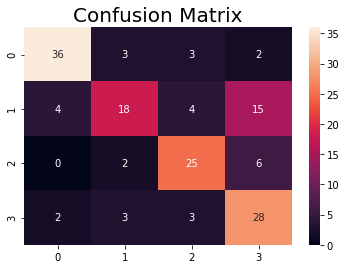

In [30]:
#confusion_matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
df_cm= pd.DataFrame(cm)
sns.heatmap(df_cm, annot=True,fmt='')
plt.title('Confusion Matrix', size=20)
plt.show()